## Importing data and libraries

In [90]:
# Import necessary libraries
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import requests

In [124]:
# Initialize a BigQuery client
client = bigquery.Client(project='container-testing-381309')

# Function to execute BigQuery and return results as a DataFrame
def run_bigquery(query):
    query_job = client.query(query)
    return query_job.to_dataframe()

# Read user_info table
user_info_query = """
SELECT *
FROM `container-testing-381309.telegram.user_info`
"""
user_info_df = run_bigquery(user_info_query)

# Read chat_history table
chat_history_query = """
SELECT *
FROM `container-testing-381309.telegram.chat_history`
"""
chat_history_df = run_bigquery(chat_history_query)

# Read chat_info table
chat_info_query = """
SELECT *
FROM `container-testing-381309.telegram.chat_info`
"""

chat_info_df = run_bigquery(chat_info_query)

#before fixing this in ETL logic, chat history was automatically adding a -100 prefix to chat_id
#To have identical chat_id in all tables, we need to remove this prefix from chat_id in chat_history table
# Remove the "-100" prefix from chat_id
chat_history_df['id'] = chat_history_df['id'].apply(lambda x: str(x)[4:] if str(x).startswith('-100') else str(x))
chat_history_df['id'] = chat_history_df['id'].astype(int)

# Merge the chat_info table to get chat names
chat_history_df = chat_history_df.merge(chat_info_df, on='id', how='left')

print(chat_history_df.head())


# Merge the chat_info table to get chat names
#chat_history_df = chat_history_df.merge(chat_info_df[['id', 'name', 'username']], left_on='chat_id', right_on='id', how='left')

# Fill in the chat name with the username if the name is missing
#chat_history_df['chat_name'] = chat_history_df['name'].fillna(chat_history_df['username'])

# Replace the chat_id with the chat name
#chat_history_df['chat_id'] = chat_history_df['chat_name']

         id                      date   from_user  \
0  17671956 2024-08-08 13:58:04+00:00  5736136094   
1  17671952 2024-08-08 13:57:14+00:00   210944655   
2  17671946 2024-08-08 13:56:48+00:00  5736136094   
3  17671920 2024-08-08 13:52:34+00:00   210944655   
4  17671890 2024-08-08 13:44:35+00:00  6585933036   

                                                text      sender     chat_id  \
0                    My crypto deposit isn't arrived  5736136094  1146170349   
1   Check this user `6454354590`, potential spammer.   210944655  1146170349   
2        The binance customer service is not helpful  5736136094  1146170349   
3  D3Unst0ppable (Binance Angel) has permanently ...   210944655  1146170349   
4                                         /price btc  6585933036  1146170349   

   is_reply  views  forwards  replies  ... edit_date via_bot  reply_to_msg_id  \
0     False      0         0        0  ...       0.0       0                0   
1     False      0         0        0 

## Analysis of different statistics

Message activity over time

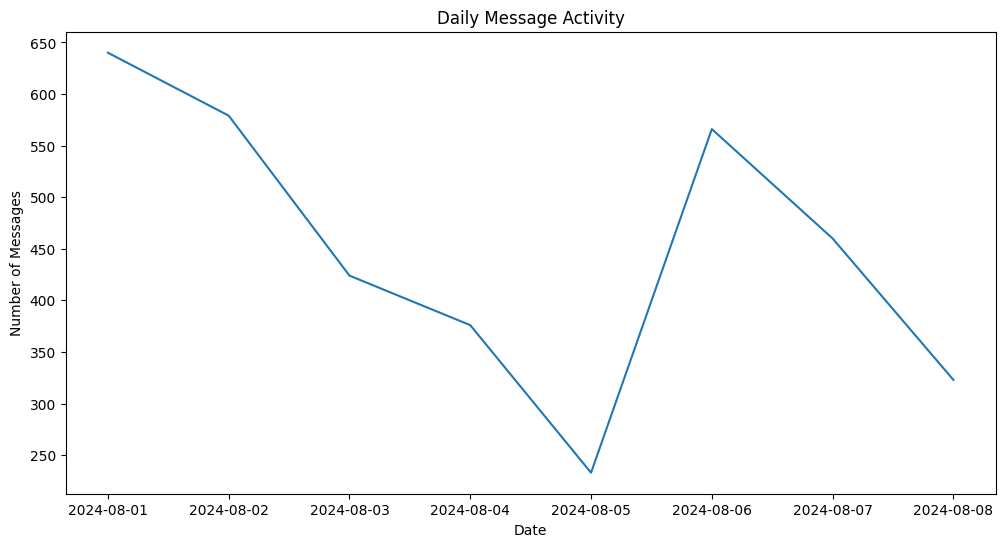

In [100]:
chat_history_df['date'] = pd.to_datetime(chat_history_df['date'])
daily_activity = chat_history_df.groupby(chat_history_df['date'].dt.date).size()

plt.figure(figsize=(12, 6))
daily_activity.plot()
plt.title('Daily Message Activity')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.show()

Top active users

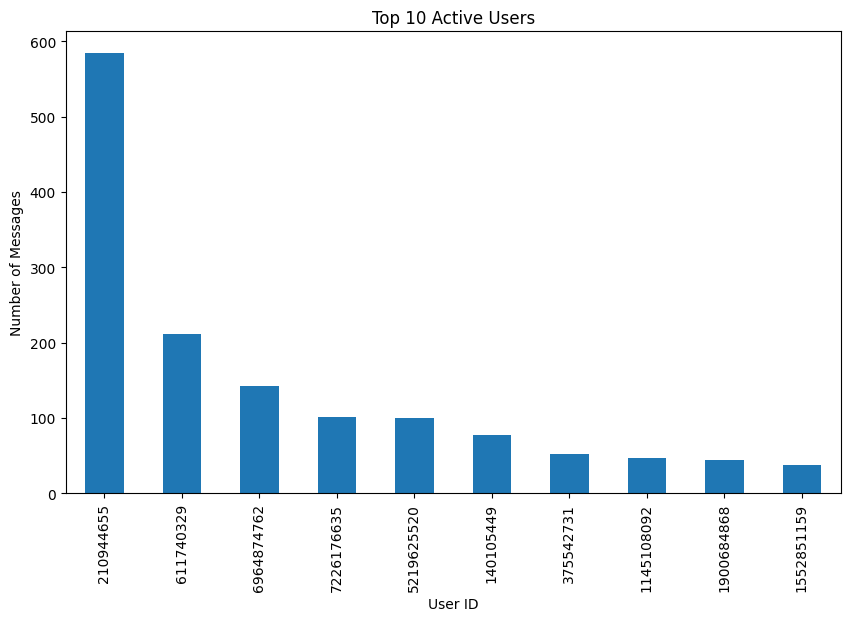

In [101]:
top_users = chat_history_df['from_user'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_users.plot(kind='bar')
plt.title('Top 10 Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Messages')
plt.show()

Message lenght destribution

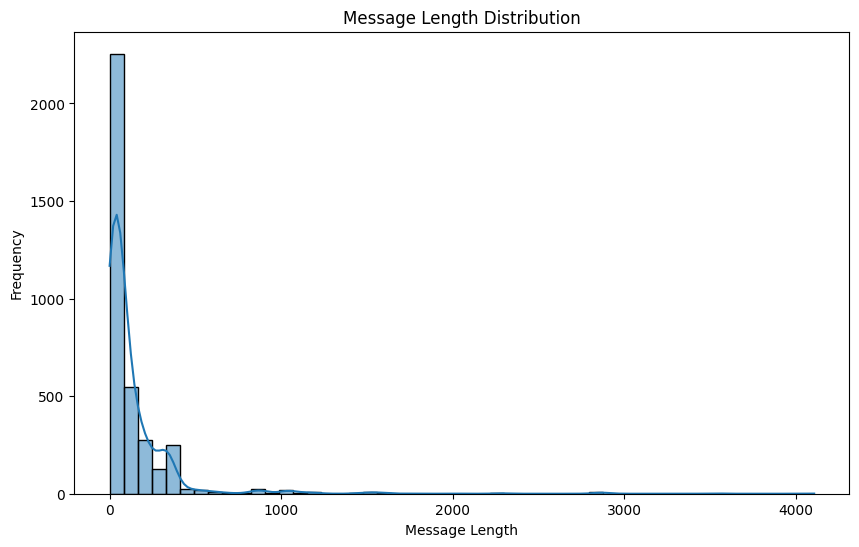

In [102]:
chat_history_df['message_length'] = chat_history_df['text'].astype(str).str.len()
plt.figure(figsize=(10, 6))
sns.histplot(chat_history_df['message_length'], bins=50, kde=True)
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

Word cloud for all massages


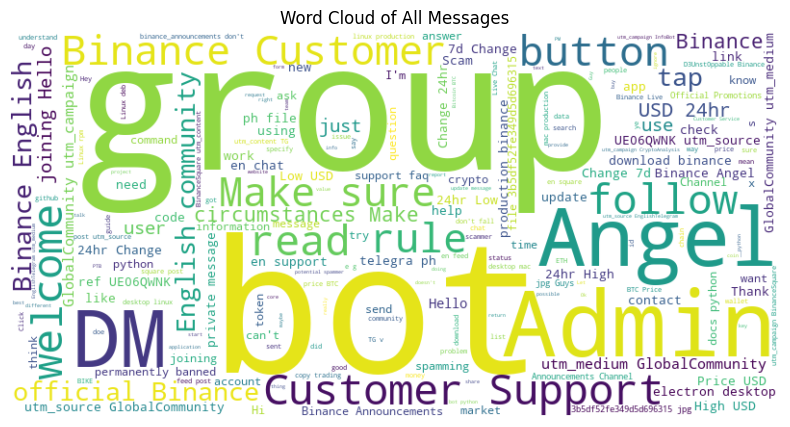

In [104]:
all_text = ' '.join(chat_history_df['text'].astype(str))
stopwords = set(CountVectorizer(stop_words='english').get_stop_words())
stopwords = stopwords.union(set(['http', 'https', 'www', 'com', 'org', 'net', 'telegram', 't', 'com']))
wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=stopwords).generate(all_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Messages')
plt.show()

User engagement summary

In [98]:
chat_history_df['has_media'] = chat_history_df['media'].notna()
chat_history_df['has_reaction'] = chat_history_df['reactions'].notna()

user_engagement = chat_history_df.groupby('from_user').agg({
    'id': 'count',
    'has_media': 'sum',
    'has_reaction': 'sum',
    'views': 'mean',
    'forwards': 'sum'
}).reset_index()

user_engagement.columns = ['user_id', 'total_messages', 'media_messages', 'messages_with_reactions', 'avg_views', 'total_forwards']

print("\nUser Engagement Summary:")
print(user_engagement.describe())


User Engagement Summary:
                 user_id  total_messages  media_messages  \
count              780.0      780.000000      780.000000   
mean   3573648755.065384        4.614103        0.421795   
std    2737005600.775431       23.845266        4.475325   
min            4746004.0        1.000000        0.000000   
25%         930230606.75        1.000000        0.000000   
50%         2072547920.0        1.000000        0.000000   
75%         6332447352.5        3.000000        0.000000   
max         7499392850.0      584.000000      110.000000   

       messages_with_reactions   avg_views  total_forwards  
count               780.000000       780.0           780.0  
mean                  4.614103   20.632504         0.39359  
std                  23.845266  559.121532       10.056845  
min                   1.000000         0.0             0.0  
25%                   1.000000         0.0             0.0  
50%                   1.000000         0.0             0.0  
75%   

Actvivity heatmap

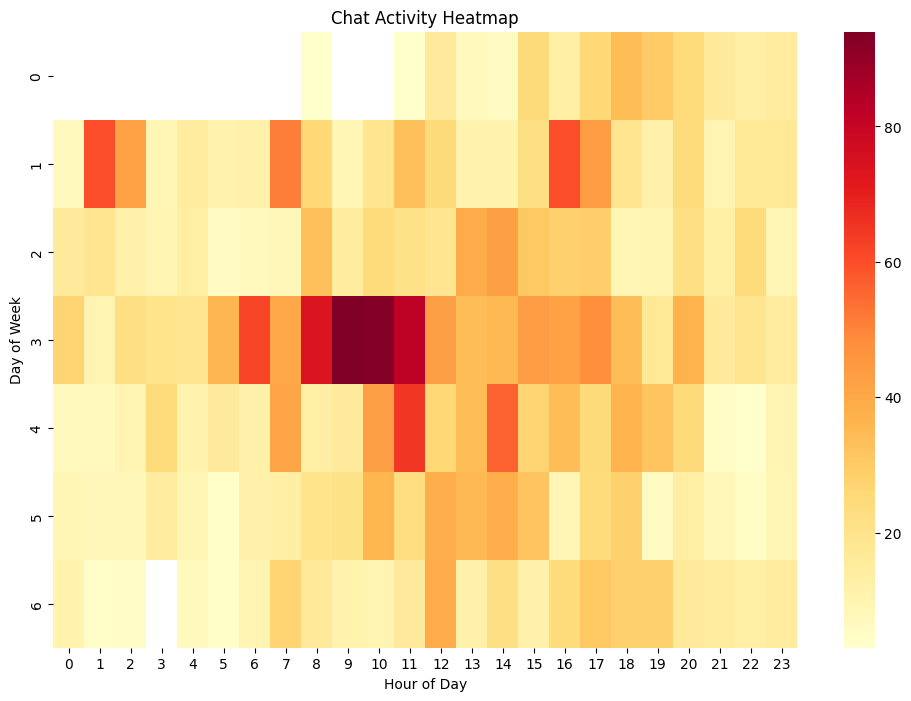

In [ ]:
chat_history_df['hour'] = chat_history_df['date'].dt.hour
chat_history_df['day_of_week'] = chat_history_df['date'].dt.dayofweek

activity_heatmap = chat_history_df.groupby(['day_of_week', 'hour']).size().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(activity_heatmap, cmap='YlOrRd')
plt.title('Chat Activity Heatmap')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

Destribution of a bot users

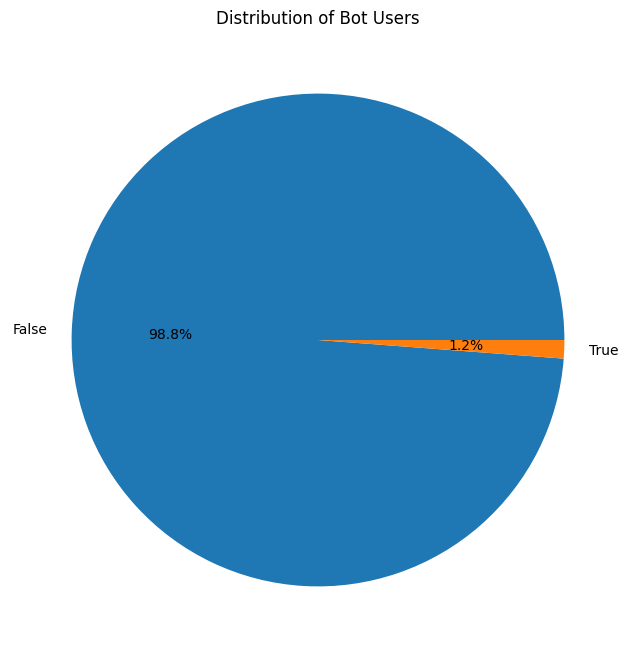

In [ ]:
bot_users = user_info_df['bot'].value_counts()
plt.figure(figsize=(8, 8))
bot_users.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Bot Users')
plt.ylabel('')
plt.show()

Moste active chats

In [122]:
#-100 is a prefix for chat_id in chat_history table, before code update -100 was automatically added to chat_id
#to make data the same this is necessary to remove the prefix
top_chats = chat_history_df['chat_id'].apply(lambda x: str(x)[4:] if str(x).startswith('-100') else str(x)).astype(int).value_counts().head(10)
print("\nTop 10 Most Active Chats:")
print(top_chats)

plt.figure(figsize=(10, 6))
top_chats.plot(kind='bar')
plt.title('Top 10 Most Active Chats')
plt.xlabel('Chat ID')
plt.ylabel('Number of Messages')
plt.show()

ValueError: invalid literal for int() with base 10: 'Binance English'

Registration order -- probably useless or maybe different presentation

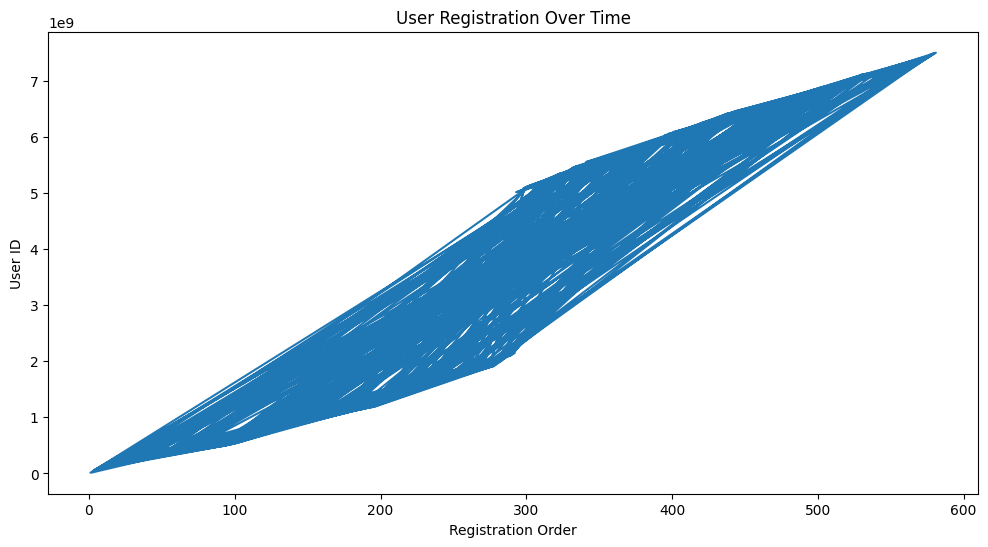

In [ ]:
user_info_df['registration_order'] = user_info_df['id'].rank(method='first')
plt.figure(figsize=(12, 6))
plt.plot(user_info_df['registration_order'], user_info_df['id'])
plt.title('User Registration Over Time')
plt.xlabel('Registration Order')
plt.ylabel('User ID')
plt.show()


## Sentimental and emotional analysis of group texts

In [112]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Function to download NRC Emotion Lexicon
def download_nrc_lexicon():
    url = "https://raw.githubusercontent.com/dinbav/LeXmo/master/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
    response = requests.get(url)
    lines = response.text.split("\n")
    lexicon = {}
    for line in lines:
        parts = line.strip().split("\t")
        if len(parts) == 3:
            word, emotion, value = parts
            if word not in lexicon:
                lexicon[word] = {}
            lexicon[word][emotion] = int(value)
    return lexicon

# Download the NRC Emotion Lexicon
nrc_lexicon = download_nrc_lexicon()

# Function to get emotions from text
def get_emotions(text):
    if pd.isna(text) or not isinstance(text, str):
        return Counter()
    words = nltk.word_tokenize(text.lower())
    emotions = Counter()
    for word in words:
        if word in nrc_lexicon:
            emotions.update({emotion: score for emotion, score in nrc_lexicon[word].items() if score > 0})
    return emotions

# Function to get sentiment
def get_sentiment(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    return TextBlob(text).sentiment.polarity

[nltk_data] Downloading package punkt to /Users/ajda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ajda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Average Sentiment: 0.09


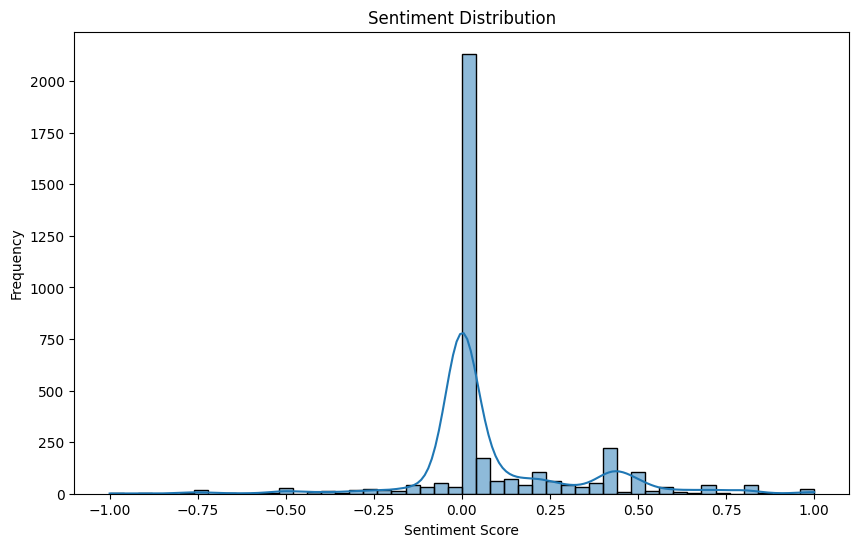

In [113]:
# Perform sentiment and emotion analysis
chat_history_df['sentiment'] = chat_history_df['text'].apply(get_sentiment)
chat_history_df['emotions'] = chat_history_df['text'].apply(get_emotions)

# Calculate average sentiment
avg_sentiment = chat_history_df['sentiment'].mean()
print(f"Average Sentiment: {avg_sentiment:.2f}")

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(chat_history_df['sentiment'], bins=50, kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

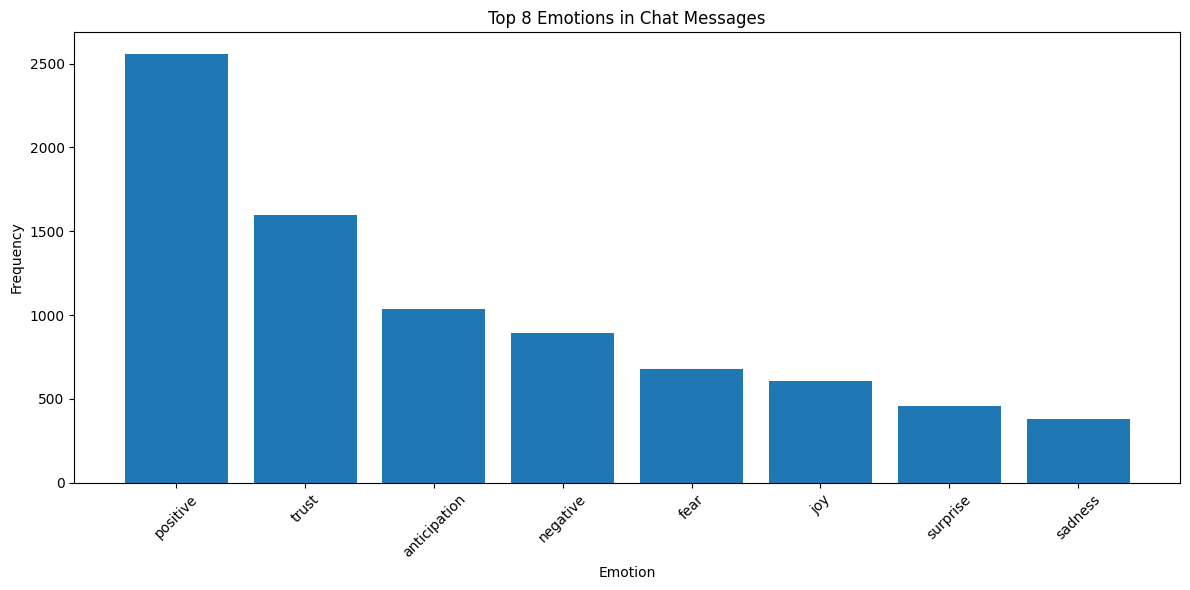

In [114]:
# Aggregate emotions across all messages
all_emotions = Counter()
for emotions in chat_history_df['emotions']:
    all_emotions.update(emotions)

# Plot top emotions
top_emotions = dict(all_emotions.most_common(8))
plt.figure(figsize=(12, 6))
plt.bar(top_emotions.keys(), top_emotions.values())
plt.title('Top 8 Emotions in Chat Messages')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

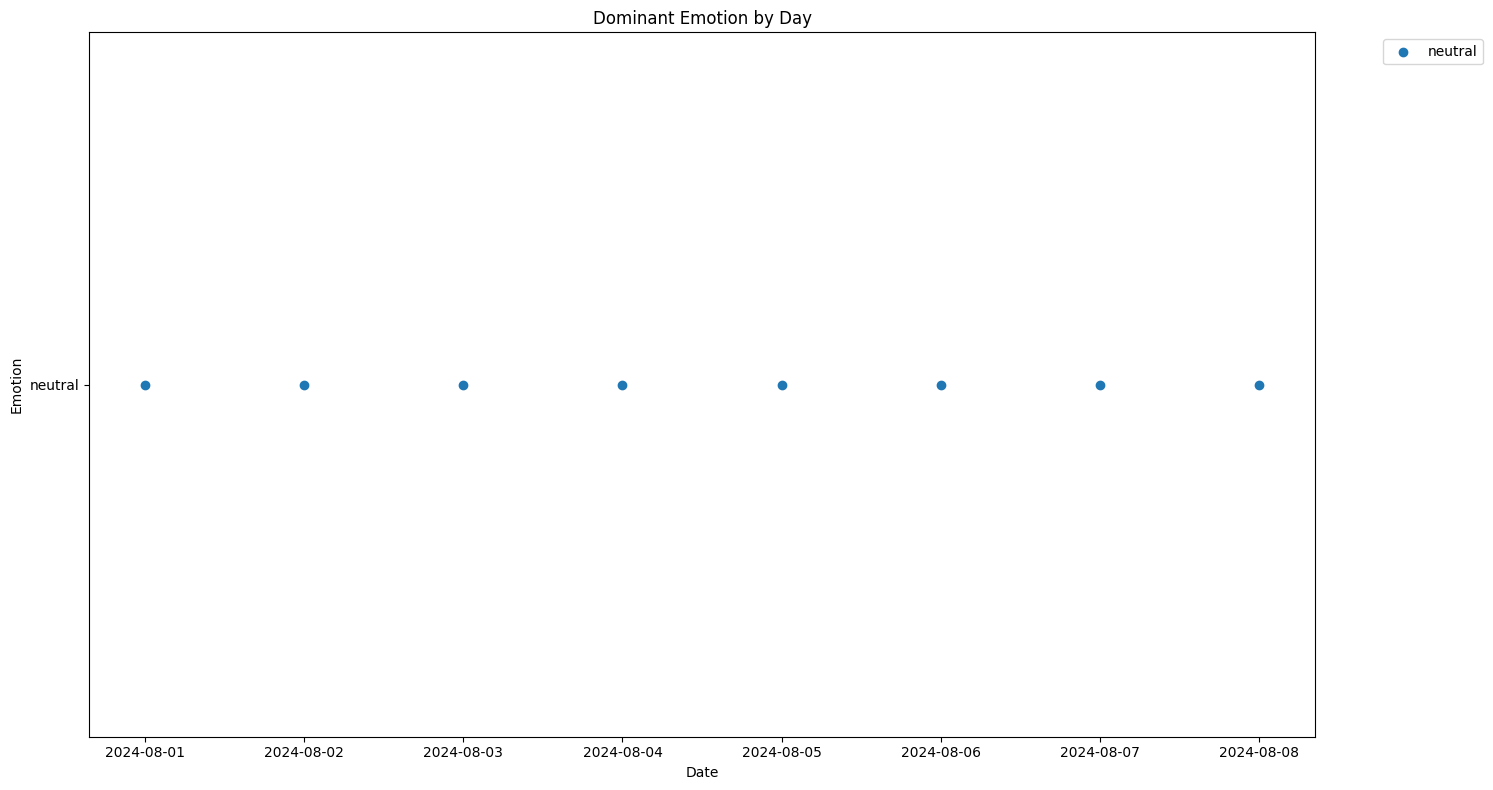

In [115]:
# Emotion over time analysis
chat_history_df['date'] = pd.to_datetime(chat_history_df['date'])
chat_history_df = chat_history_df.set_index('date')

# Function to get the dominant emotion
def get_dominant_emotion(emotions):
    return max(emotions, key=emotions.get) if emotions else 'neutral'

chat_history_df['dominant_emotion'] = chat_history_df['emotions'].apply(get_dominant_emotion)

# Resample by day and get the most common emotion
daily_emotion = chat_history_df['dominant_emotion'].resample('D').agg(lambda x: x.value_counts().index[0] if len(x) > 0 else 'neutral')

# Plot emotions over time
plt.figure(figsize=(15, 8))
for emotion in set(daily_emotion.values):
    emotion_days = daily_emotion[daily_emotion == emotion].index
    plt.scatter(emotion_days, [emotion] * len(emotion_days), label=emotion)

plt.title('Dominant Emotion by Day')
plt.xlabel('Date')
plt.ylabel('Emotion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Correlation between sentiment and message length: 0.08


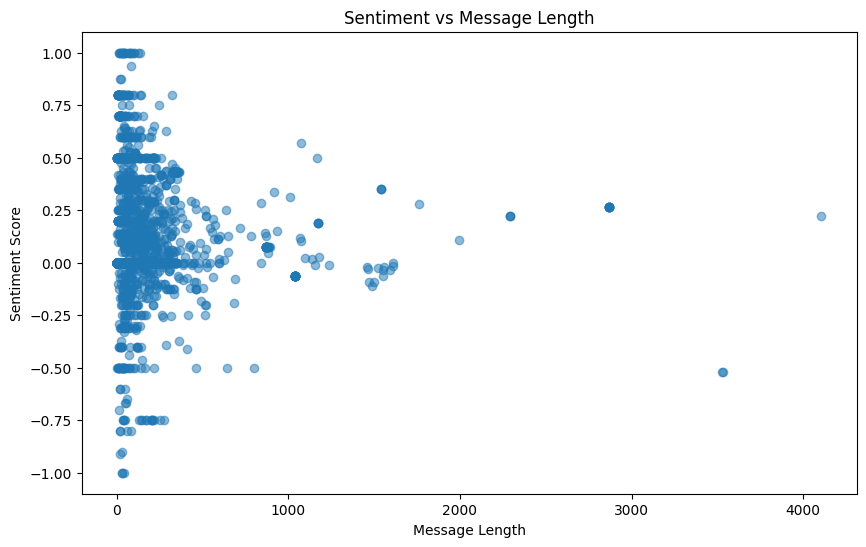

In [116]:
# Correlation between sentiment and message length
#The correlation value ranges from -1 to 1, where -1 represents a strong negative correlation,
#0 represents no correlation, and 1 represents a strong positive correlation.
chat_history_df['message_length'] = chat_history_df['text'].fillna('').astype(str).str.len()
correlation = chat_history_df['sentiment'].corr(chat_history_df['message_length'])
print(f"Correlation between sentiment and message length: {correlation:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(chat_history_df['message_length'], chat_history_df['sentiment'], alpha=0.5)
plt.title('Sentiment vs Message Length')
plt.xlabel('Message Length')
plt.ylabel('Sentiment Score')
plt.show()

In [117]:
# Emotion analysis for top users
top_users = chat_history_df['from_user'].value_counts().head(5).index
for user in top_users:
    user_emotions = Counter()
    for emotions in chat_history_df[chat_history_df['from_user'] == user]['emotions']:
        user_emotions.update(emotions)
    
    print(f"\nTop 5 emotions for user {user}:")
    print(dict(user_emotions.most_common(5)))


Top 5 emotions for user 210944655:
{'positive': 946, 'trust': 591, 'anticipation': 230, 'joy': 179, 'negative': 153}

Top 5 emotions for user 611740329:
{'positive': 62, 'trust': 49, 'anticipation': 39, 'negative': 31, 'fear': 21}

Top 5 emotions for user 6964874762:
{'fear': 261, 'anticipation': 71, 'negative': 68, 'positive': 68, 'anger': 47}

Top 5 emotions for user 7226176635:
{'positive': 48, 'trust': 24, 'anticipation': 22, 'negative': 15, 'joy': 7}

Top 5 emotions for user 5219625520:
{'positive': 54, 'anticipation': 40, 'trust': 37, 'joy': 30, 'surprise': 14}


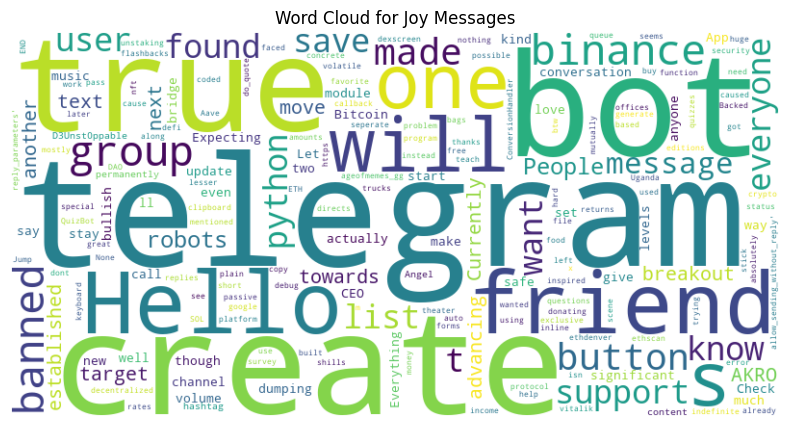

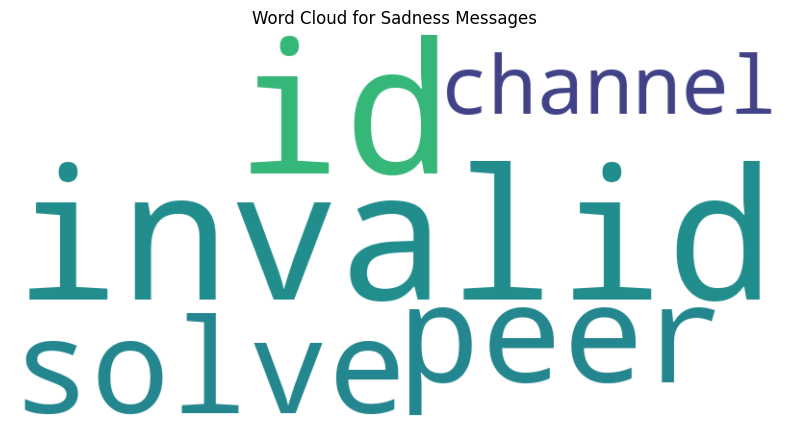

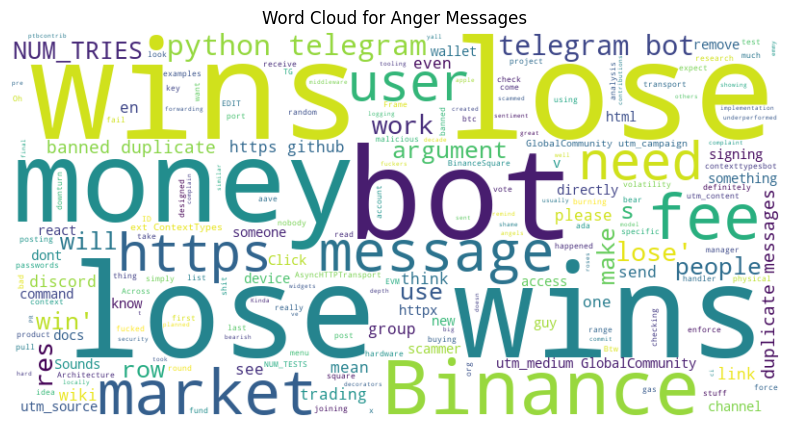

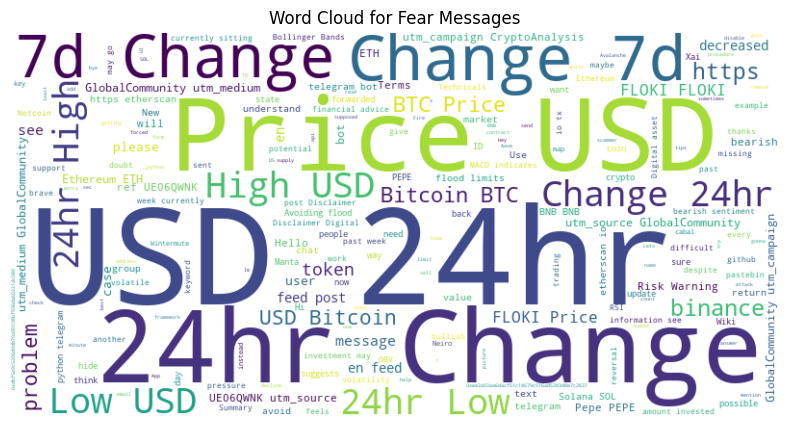

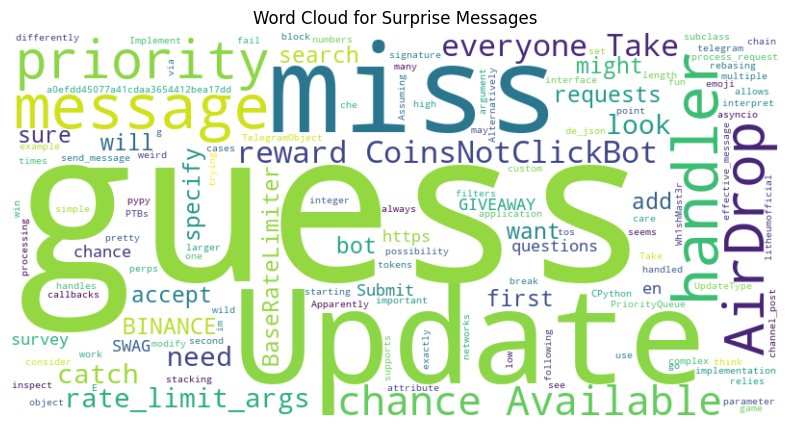

In [118]:
# Word cloud for each emotion

for emotion in ['joy', 'sadness', 'anger', 'fear', 'surprise']:
    emotion_words = ' '.join(chat_history_df[chat_history_df['dominant_emotion'] == emotion]['text'].fillna('').astype(str))
    if emotion_words.strip():  # Check if there are any words for this emotion
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_words)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {emotion.capitalize()} Messages')
        plt.show()
    else:
        print(f"No words found for emotion: {emotion}")